<font size=3> 
    Here I literally use the example shown by: https://docs.astropy.org/en/stable/convolution/index.html


In [3]:
pip install sep

     |████████████████████████████████| 268 kB 3.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:

# Finding peak element in a 2D Array.
def findPeakGrid(mat):
    stcol = 0
    endcol = len(mat[0]) - 1; # Starting po  end po of Search Space
 
    while (stcol <= endcol):  # Bin Search Condition
 
        midcol = stcol + int((endcol - stcol) / 2)
        ansrow = 0;
        # "ansrow" To keep the row number of global Peak
        # element of a column
 
        # Finding the row number of Global Peak element in
        # Mid Column.
        for r in range(len(mat)):
            ansrow = r if mat[r][midcol] >= mat[ansrow][midcol] else ansrow;
         
 
        # Finding next Search space will be left or right
        valid_left =  midcol - 1 >= stcol and mat[ansrow][midcol - 1] > mat[ansrow][midcol];
        valid_right = midcol + 1 <= endcol and mat[ansrow][midcol + 1] > mat[ansrow][midcol];
 
        # if we're at Peak Element
        if (not valid_left and not valid_right) :
            return [ ansrow, midcol ];
         
 
        elif (valid_right):
            stcol = midcol  + 1; # move the search space in right
        else:
            endcol = midcol  - 1; # move the search space in left
     
    return [ -1, -1 ];
 
# Driver Code
arr = [[7, 8, 5], [9 ,8, 6], [3, 5, 0]];
result = findPeakGrid(arr);
print("Peak element found at index:", result)

Peak element found at index: [1, 0]


In [5]:
import sys
sys.path.append( '../astro_pola' )

import pickle
from _astro_functions import ABMagToFluxJy, compare_to, Select_largest_flux
#from _photometric_calib import Select_largest_flux
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve
from matplotlib.colors import LogNorm

sys.path.append('../..')

import os 
import sep 

# Blind15A_16_N24
<font size=3> From Jorges light curve construction we see that for this particular exposure-detector, the worst seeing is 1.4417, this corresponds to the FWHM of the exposure. Therefore we will convolve with a gaussian Kernel that has a fhwm of 1.4417 

In [6]:
worst_seeing = 1.44175923
sigma2fwhm = 2.*np.sqrt(2.*np.log(2.)) 
stdev = worst_seeing/sigma2fwhm
arcsec_to_pixel = 0.27#626 # arcsec/pixel
stdev/=arcsec_to_pixel # we transform to pixel values 
kernel = Gaussian2DKernel(x_stddev=stdev)

directory = 'Blind15A_16_N24'

file = '{}_convolved.pickle'.format(directory)

if not os.path.exists(file):
    convolved_images = {}
    
    # Here I convolve all the images in the Blind15A_16_N24 directory, and save them in 
    # the convolved_images dictionary 

    for filename in os.listdir(directory):
        if filename.endswith('.fits'):
            fitsfile = get_pkg_data_filename(directory+'/'+filename)
            img = fits.open(fitsfile)[1]
            astropy_conv = convolve(img.data, kernel)
            visit = filename.split('_')[11]
            convolved_images[visit] = astropy_conv
            
    with open(file, 'wb') as handle:
        
        pickle.dump(convolved_images, handle, protocol = pickle.HIGHEST_PROTOCOL)
else:
    with open(file, 'rb') as handle:
        convolved_images = pickle.load(handle)
   


In [7]:
r = worst_seeing/arcsec_to_pixel


In [5]:
r*.75

4.004886749999999

<font size=3> After doing convolution of the images, I do the light curve construction using SEP

In [8]:
info = pd.read_csv('info_Blind15A_16_p2.txt').sort_values('mjd')
stars = pd.read_csv('stars_from_Blind15A_16_p2.txt')


In [7]:
convolved_images['410905']

objects = sep.extract(data_cut, 100, minarea=40)

array([[-0.2640348 , -0.33532947, -0.38823825, ...,  0.3907179 ,
         0.33719432,  0.26533264],
       [-0.3350592 , -0.42553145, -0.4926718 , ...,  0.49646252,
         0.4284529 ,  0.3371423 ],
       [-0.38752648, -0.4921652 , -0.569818  , ...,  0.57515514,
         0.49636504,  0.39058086],
       ...,
       [ 0.01883237,  0.02327533,  0.0259999 , ..., -0.5080221 ,
        -0.43823662, -0.3447219 ],
       [ 0.01652163,  0.02042896,  0.02283479, ..., -0.43882683,
        -0.37854683, -0.29776946],
       [ 0.01316672,  0.0162864 ,  0.01821315, ..., -0.34555104,
        -0.2980842 , -0.23447673]], dtype=float32)

In [9]:
(1/0.27)**2 *np.pi #arcsec/pixel

43.09454943195875

[34454.00927353]


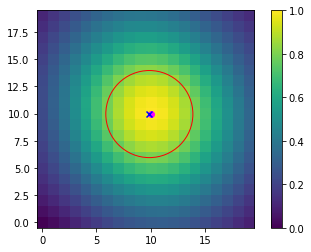

[34687.61242294]


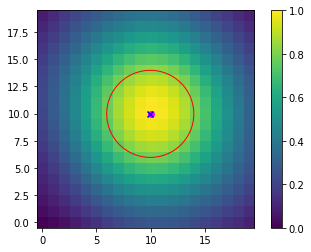

[34285.65600777]


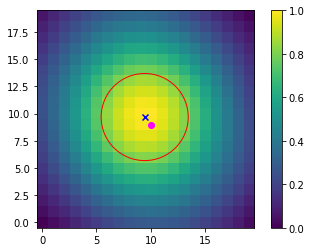

[31223.01829052]


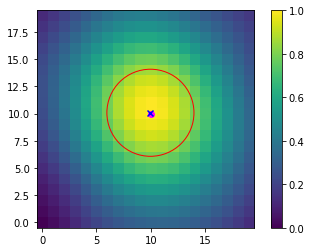

[33992.89266205]


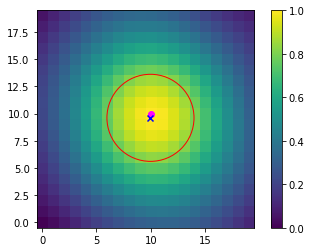

[35352.93314743]


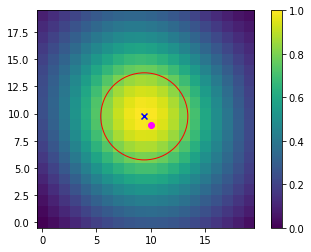

[34320.80581284]


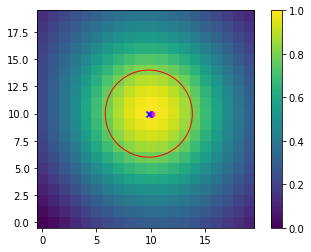

[31687.57286644]


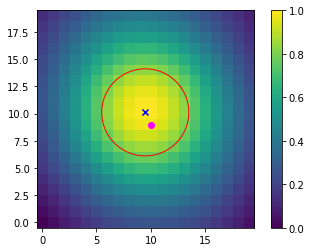

In [12]:
fluxes = []
fluxes_err = []
cutout = 10
r = worst_seeing/arcsec_to_pixel
for index, row in info.iterrows():
        
    data = convolved_images[str(int(row.visit))]
    
    data_cut = data[int(row.y_pix-cutout): int(row.y_pix+cutout),int(row.x_pix-cutout): int(row.x_pix+cutout)].copy(order='C')
    
    result = findPeakGrid(data_cut)
    #print("Peak element found at index:", result)

    
    plt.imshow(data_cut, norm=LogNorm(), origin='lower')
    objects = sep.extract(data_cut, 20, minarea=20)
    obj, j = Select_largest_flux(data_cut, objects)
    plt.scatter(result[0], result[1], marker='o', color='magenta')
    for i in range(len(objects)):
        plt.scatter(objects['x'][i], objects['y'][i], marker='x', color='blue')
        
    circle = plt.Circle((obj['x'],obj['y']), radius = r*.75, color='red', fill = False)
    plt.gca().add_patch(circle)
    plt.colorbar()
    plt.show()
    flux, fluxerr, flag = sep.sum_circle(data_cut, objects['x'][j], objects['y'][j], r*1.5) # fixed aperture 
    #flux, fluxerr, flag = sep.sum_circle(data_cut,[result[0]],[result[1]], r*.75) # fixed aperture 
    
    fluxes.append(flux[0])
    fluxes_err.append(fluxerr[0])

    
    

In [10]:
dates, f_jorge, ferr_jorge = compare_to('Blind15A_16_N24_1292_3950_g_psf_ff.csv', sfx='flx', factor=0.75)
dates, m_jorge, merr_jorge = compare_to('Blind15A_16_N24_1292_3950_g_psf_ff.csv', sfx='mag', factor=0.75)
fjy_jorge, ferrjy_jorge = ABMagToFluxJy(m_jorge, mab_err=merr_jorge)


In [145]:
f_jorge

0    10005.905431
1    11202.196974
2    10808.660049
3     9124.412401
4     9706.951374
5    11271.581307
6    10905.771043
7    10077.737796
Name: aperture_flx_1, dtype: float64

Text(0, 0.5, 'Flux [nJy]')

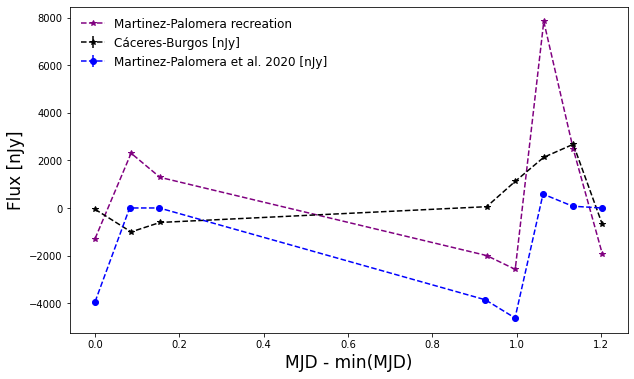

In [12]:
plt.figure(figsize=(10,6))
plt.errorbar(info.mjd - min(info.mjd), fluxes*info.calib -np.median(fluxes*info.calib) , yerr=fluxes_err*info.calib ,fmt='*', ls='--', color='black', label='Cáceres-Burgos [nJy]')
plt.errorbar(dates, fjy_jorge*1e9 - np.median(fjy_jorge*1e9), yerr=ferrjy_jorge, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')
plt.plot(info.mjd - min(info.mjd), f_jorge*info.calib - np.median(f_jorge*info.calib),'*', ls='--', color='purple', label='Martinez-Palomera recreation')

#plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9 - np.median( ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9),'*', ls='dotted', color='red', label='Caceres-Burgos recreation')


#plt.errorbar(dates, f_jorge - np.median(f_jorge), yerr=ferr_jorge, fmt='o', ls='--',color='magenta', label='Martinez-Palomera et al. 2020 [ADU]')
#plt.errorbar(info.mjd - min(info.mjd), fluxes - np.median(fluxes) ,yerr=fluxes_err,fmt='*', ls='--', color='red', label='Caceres-Burgos [ADU]')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('Flux [nJy]', fontsize=17)

Text(0, 0.5, 'Flux [nJy]')

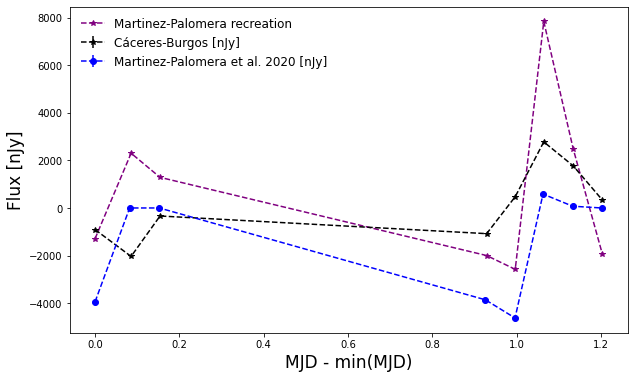

In [14]:
plt.figure(figsize=(10,6))
plt.errorbar(info.mjd - min(info.mjd), fluxes*info.calib -np.median(fluxes*info.calib) , yerr=fluxes_err*info.calib ,fmt='*', ls='--', color='black', label='Cáceres-Burgos [nJy]')
plt.errorbar(dates, fjy_jorge*1e9 - np.median(fjy_jorge*1e9), yerr=ferrjy_jorge, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')
plt.plot(info.mjd - min(info.mjd), f_jorge*info.calib - np.median(f_jorge*info.calib),'*', ls='--', color='purple', label='Martinez-Palomera recreation')

#plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9 - np.median( ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9),'*', ls='dotted', color='red', label='Caceres-Burgos recreation')


#plt.errorbar(dates, f_jorge - np.median(f_jorge), yerr=ferr_jorge, fmt='o', ls='--',color='magenta', label='Martinez-Palomera et al. 2020 [ADU]')
#plt.errorbar(info.mjd - min(info.mjd), fluxes - np.median(fluxes) ,yerr=fluxes_err,fmt='*', ls='--', color='red', label='Caceres-Burgos [ADU]')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('Flux [nJy]', fontsize=17)

Text(0, 0.5, 'Flux [nJy]')

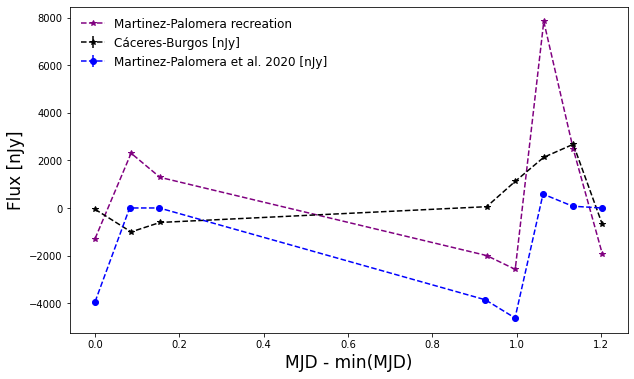

In [13]:
plt.figure(figsize=(10,6))
plt.errorbar(info.mjd - min(info.mjd), fluxes*info.calib -np.median(fluxes*info.calib) , yerr=fluxes_err*info.calib ,fmt='*', ls='--', color='black', label='Cáceres-Burgos [nJy]')
plt.errorbar(dates, fjy_jorge*1e9 - np.median(fjy_jorge*1e9), yerr=ferrjy_jorge, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')
plt.plot(info.mjd - min(info.mjd), f_jorge*info.calib - np.median(f_jorge*info.calib),'*', ls='--', color='purple', label='Martinez-Palomera recreation')

#plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9 - np.median( ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9),'*', ls='dotted', color='red', label='Caceres-Burgos recreation')


#plt.errorbar(dates, f_jorge - np.median(f_jorge), yerr=ferr_jorge, fmt='o', ls='--',color='magenta', label='Martinez-Palomera et al. 2020 [ADU]')
#plt.errorbar(info.mjd - min(info.mjd), fluxes - np.median(fluxes) ,yerr=fluxes_err,fmt='*', ls='--', color='red', label='Caceres-Burgos [ADU]')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('Flux [nJy]', fontsize=17)

In [134]:
ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9

0    45424.451653
1    45968.726177
2    44717.250913
3    38695.110833
4    44927.850880
5    47325.863059
6    45619.613626
7    45326.649847
8             NaN
dtype: float64

In [93]:
2.5*np.log10(info.expTime)

2    4.836246
1    4.836246
0    4.836246
5    4.836246
6    4.836246
7    4.836246
4    4.836246
3    4.836246
Name: expTime, dtype: float64

Text(0, 0.5, 'Excess flux')

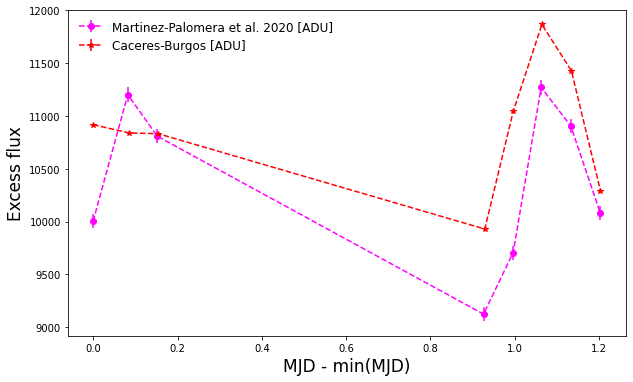

In [77]:
plt.figure(figsize=(10,6))
plt.errorbar(dates, f_jorge, yerr=ferr_jorge, fmt='o', ls='--',color='magenta', label='Martinez-Palomera et al. 2020 [ADU]')
plt.errorbar(info.mjd - min(info.mjd), fluxes ,yerr=fluxes_err,fmt='*', ls='--', color='red', label='Caceres-Burgos [ADU]')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('Excess flux', fontsize=17)

Text(0, 0.5, 'magnitude')

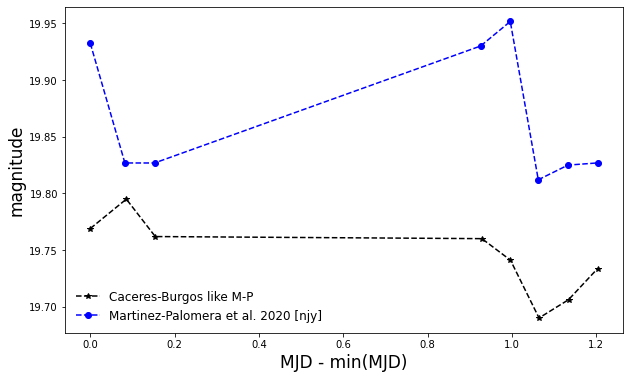

In [9]:


plt.figure(figsize=(10,6))
plt.plot(info.mjd - min(info.mjd), -2.5*np.log10(fluxes) + info.zp,'*', ls='--', color='black', label='Caceres-Burgos like M-P')
plt.plot(dates, m_jorge, 'o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [njy]')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('magnitude', fontsize=17)

# Blind15A_24_S16

In [ ]:
1.25280054

In [21]:
r*.75

3.578065498857578

In [14]:
worst_seeing = 1.25280054
sigma2fwhm = 2.*np.sqrt(2.*np.log(2.)) 
stdev = worst_seeing/sigma2fwhm
arcsec_to_pixel = 0.27#626 # arcsec/pixel
stdev/=arcsec_to_pixel # we transform to pixel values 
kernel = Gaussian2DKernel(x_stddev=stdev)

directory = 'Blind15A_24_S16'
#convolved_images = {}

# Here I convolve all the images in the Blind15A_16_N24 directory, and save them in 
# the convolved_images dictionary 

file = '{}_convolved.pickle'.format(directory)

if not os.path.exists(file):
    convolved_images = {}
    
    # Here I convolve all the images in the Blind15A_16_N24 directory, and save them in 
    # the convolved_images dictionary 

    for filename in os.listdir(directory):
        if filename.endswith('.fits'):
            fitsfile = get_pkg_data_filename(directory+'/'+filename)
            img = fits.open(fitsfile)[1]
            astropy_conv = convolve(img.data, kernel)
            visit = filename.split('_')[11]
            convolved_images[visit] = astropy_conv
            
    with open(file, 'wb') as handle:
        
        pickle.dump(convolved_images, handle, protocol = pickle.HIGHEST_PROTOCOL)
else:
    with open(file, 'rb') as handle:
        convolved_images = pickle.load(handle)
   
        
info = pd.read_csv('info_Blind15A_24.txt').sort_values('mjd')


[16447.15147734]


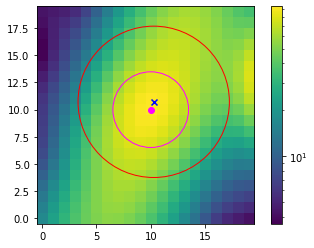

[16510.60062689]


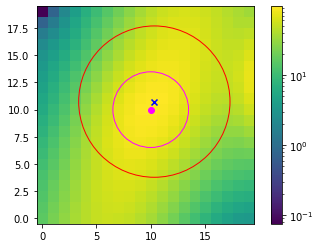

[15619.4917466]


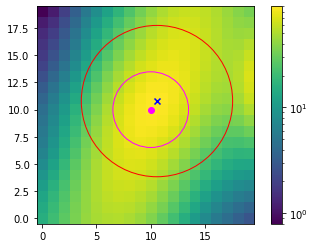

[14731.33674434]


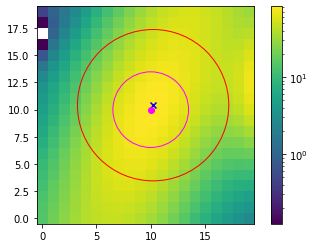

[14381.30833447]


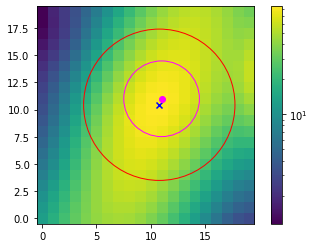

[15615.01868176]


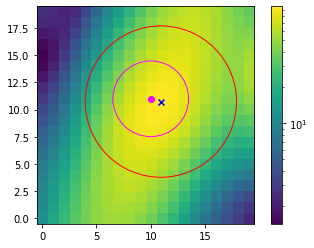

[15950.15063298]


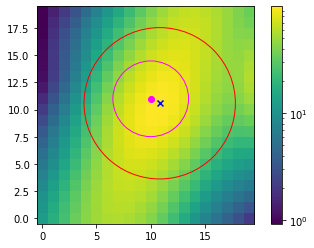

[15993.03637886]


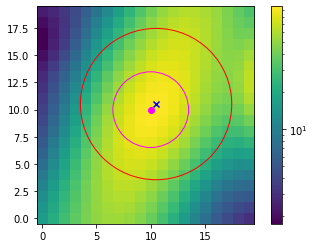

[14562.84215057]


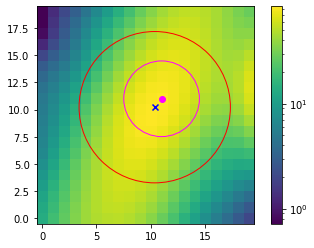

In [19]:
fluxes = []
fluxes_err = []
cutout = 10
r = worst_seeing/arcsec_to_pixel
for index, row in info.iterrows():
    data = convolved_images[str(int(row.visit))]
    
    data_cut = data[int(row.y_pix-cutout): int(row.y_pix+cutout),int(row.x_pix-cutout): int(row.x_pix+cutout)].copy(order='C')
    plt.imshow(data_cut, norm=LogNorm(), origin='lower')
    plt.colorbar()
    objects = sep.extract(data_cut, 60, minarea=30)
    obj, j = Select_largest_flux(data_cut, objects)
    for i in range(len(objects)):
        plt.scatter(objects['x'][i], objects['y'][i], marker='x', color='blue')
        
    circle = plt.Circle((obj['x'],obj['y']), radius = r*1.5, color='red', fill = False)
    plt.gca().add_patch(circle)
    
    
    #r = row.psf/arcsec_to_pixel
    
    result = findPeakGrid(data_cut)
    plt.scatter(result[0], result[1], marker='o', color='magenta')
    circle = plt.Circle((result[0], result[1]), radius = r*.75, color='magenta', fill = False)
    plt.gca().add_patch(circle)
    plt.show()
    #flux, fluxerr, flag = sep.sum_circle(data_cut, [result[0]],[result[1]], r*.75) # fixed aperture 
    flux, fluxerr, flag = sep.sum_circle(data_cut, obj['x'],obj['y'], r*1.5) # fixed aperture 
    
    fluxes.append(flux[0])
    fluxes_err.append(fluxerr[0])

    
    

In [17]:
dates, f_jorge, ferr_jorge = compare_to('Blind15A_24_S16_0547_2878_g_psf_ff.csv', sfx='flx', factor=0.75)
dates, m_jorge, merr_jorge = compare_to('Blind15A_24_S16_0547_2878_g_psf_ff.csv', sfx='mag', factor=0.75)
fjy_jorge, ferrjy_jorge = ABMagToFluxJy(m_jorge, mab_err=merr_jorge)


Text(0, 0.5, 'Flux [nJy]')

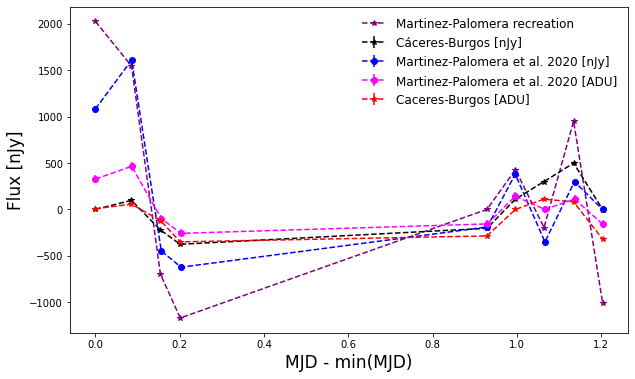

In [161]:
plt.figure(figsize=(10,6))
plt.errorbar(info.mjd - min(info.mjd), fluxes*info.calib -np.median(fluxes*info.calib) , yerr=fluxes_err*info.calib ,fmt='*', ls='--', color='black', label='Cáceres-Burgos [nJy]')
plt.errorbar(dates, fjy_jorge*1e9 - np.median(fjy_jorge*1e9), yerr=ferrjy_jorge, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')
plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9 - np.median(ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9),'*', ls='--', color='purple', label='Martinez-Palomera recreation')
#plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(fluxes) +  info.zp)*1e9,'*', ls='dotted', color='red', label='Caceres-Burgos recreation')
plt.errorbar(dates, f_jorge - np.median(f_jorge), yerr=ferr_jorge, fmt='o', ls='--',color='magenta', label='Martinez-Palomera et al. 2020 [ADU]')
plt.errorbar(info.mjd - min(info.mjd), fluxes - np.median(fluxes) ,yerr=fluxes_err,fmt='*', ls='--', color='red', label='Caceres-Burgos [ADU]')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('Flux [nJy]', fontsize=17)

Text(0, 0.5, 'Excess flux')

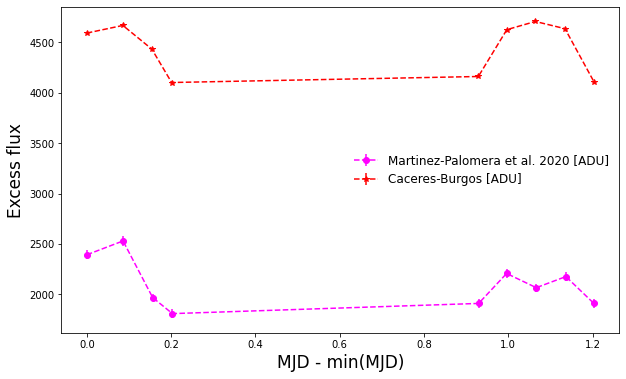

In [25]:
plt.figure(figsize=(10,6))
plt.errorbar(dates, f_jorge, yerr=ferr_jorge, fmt='o', ls='--',color='magenta', label='Martinez-Palomera et al. 2020 [ADU]')
plt.errorbar(info.mjd - min(info.mjd), np.array(fluxes)/1.5 * .75 ,yerr=fluxes_err,fmt='*', ls='--', color='red', label='Caceres-Burgos [ADU]')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('Excess flux', fontsize=17)

Text(0, 0.5, 'magnitude')

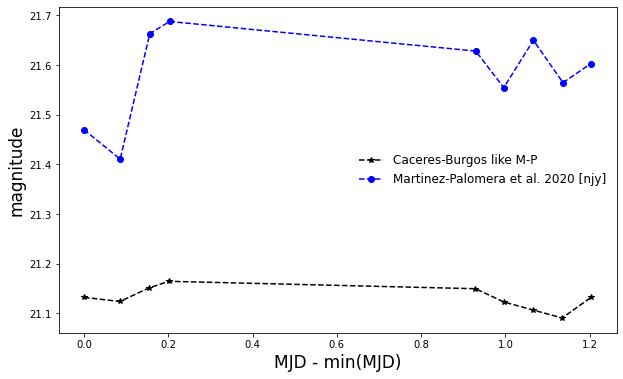

In [163]:
plt.figure(figsize=(10,6))
plt.plot(info.mjd - min(info.mjd), -2.5*np.log10(fluxes)+ info.zp,'*', ls='--', color='black', label='Caceres-Burgos like M-P')
plt.plot(dates, m_jorge, 'o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [njy]')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('magnitude', fontsize=17)

In [65]:
-2.5*np.log10(fluxes) + info.zp # + 2.5*np.log10(info.expTime)

2    21.131298
1    21.118506
3    21.149856
0    21.159965
7    21.147363
6    21.091211
8    21.085308
5    21.093664
4    21.124470
Name: zp, dtype: float64

In [27]:
2.5*np.log10(info.expTime) - info.zp

2   -25.021996
1   -25.030856
3   -24.995126
0   -24.921171
7   -24.931277
6   -25.010016
8   -25.032406
5   -25.005970
4   -24.900172
dtype: float64

Text(0, 0.5, 'Flux [nJy]')

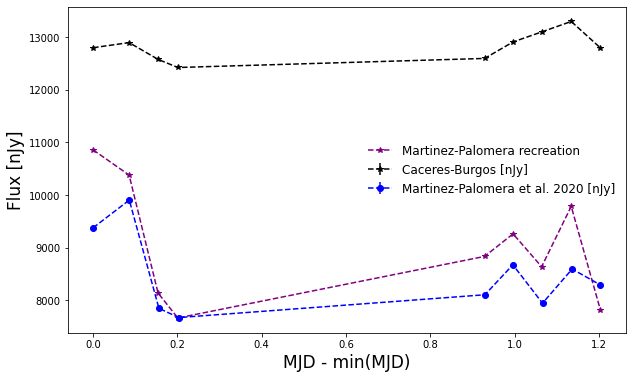

In [19]:
plt.figure(figsize=(10,6))
plt.errorbar(info.mjd - min(info.mjd), fluxes*info.calib, yerr=fluxes_err*info.calib ,fmt='*', ls='--', color='black', label='Caceres-Burgos [nJy]')
plt.errorbar(dates, fjy_jorge*1e9, yerr=ferrjy_jorge, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')
#plt.errorbar(dates, f_jorge*info.calib, yerr=ferr_jorge*info.calib, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')

plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9,'*', ls='--', color='purple', label='Martinez-Palomera recreation')
#plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(fluxes) +  info.zp)*1e9,'*', ls='dotted', color='red', label='Caceres-Burgos recreation')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('Flux [nJy]', fontsize=17)

Text(0, 0.5, 'Flux [nJy]')

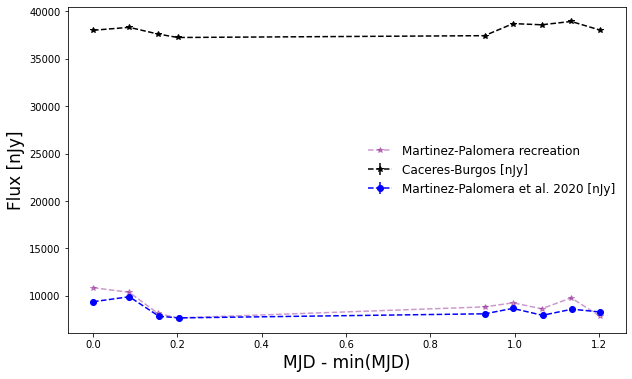

In [22]:
plt.figure(figsize=(10,6))
plt.errorbar(info.mjd - min(info.mjd), fluxes*info.calib , yerr=fluxes_err*info.calib ,fmt='*', ls='--', color='black', label='Caceres-Burgos [nJy]')
plt.errorbar(dates, fjy_jorge*1e9 , yerr=ferrjy_jorge, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')
#plt.errorbar(dates, f_jorge*info.calib, yerr=ferr_jorge*info.calib, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')

plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9,'*', ls='--', color='purple', alpha=0.4,label='Martinez-Palomera recreation')
#plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(fluxes) +  info.zp)*1e9,'*', ls='dotted', color='red', label='Caceres-Burgos recreation')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('Flux [nJy]', fontsize=17)

Text(0, 0.5, 'Flux [nJy]')

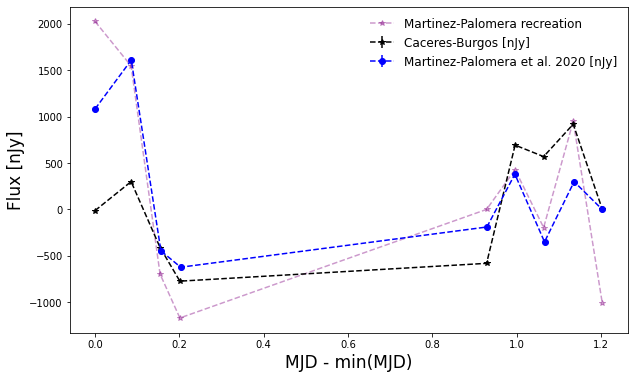

In [20]:
plt.figure(figsize=(10,6))
plt.errorbar(info.mjd - min(info.mjd), fluxes*info.calib - np.median(fluxes*info.calib), yerr=fluxes_err*info.calib ,fmt='*', ls='--', color='black', label='Caceres-Burgos [nJy]')
plt.errorbar(dates, fjy_jorge*1e9 - np.median(fjy_jorge*1e9), yerr=ferrjy_jorge, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')
#plt.errorbar(dates, f_jorge*info.calib, yerr=ferr_jorge*info.calib, fmt='o', ls='--', color='blue', label='Martinez-Palomera et al. 2020 [nJy]')

plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9 - np.median(ABMagToFluxJy(-2.5*np.log10(f_jorge) +  info.zp)*1e9),'*', ls='--', color='purple', alpha=0.4,label='Martinez-Palomera recreation')
#plt.plot(info.mjd - min(info.mjd), ABMagToFluxJy(-2.5*np.log10(fluxes) +  info.zp)*1e9,'*', ls='dotted', color='red', label='Caceres-Burgos recreation')

plt.legend(frameon=False, fontsize=12)
plt.xlabel('MJD - min(MJD)', fontsize=17)
plt.ylabel('Flux [nJy]', fontsize=17)